# GAN example

In [1]:
# import necessary packages

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.config.list_physical_devices('GPU')

[]

In [2]:
noise_dim = 100 

In [3]:
# creating the dataset of real images
size = 32

def create_images_vert(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(10):
            x0 = random.randrange(5,size-5)
            sample = cv2.line(sample,(x0,0),(x0,size-1),(255,255,255),1)
        #sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
        #sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def create_images_diag(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(3):
            x0 = random.randrange(-size/2,size/2)
            sample = cv2.line(sample,(x0,0),(x0+32,32),(255,255,255),2)
        sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
        sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def load_images(dir):
    samples = []
    for image_file in os.listdir(dir):
        if image_file.endswith("jpg"):
            sample = cv2.imread(f"{dir}/{image_file}")
            sample = cv2.resize(sample, (32,32))
            sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
            sample = np.expand_dims(sample,axis=2)
            samples.append(sample)
    return samples

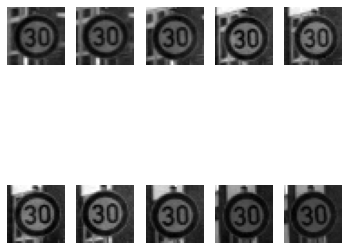

In [18]:
#samples = create_images_vert(1000)
#samples = create_images_diag(1000)
samples = load_images('signs')
samples = np.array(samples)
samples = samples/255

plt.figure(figsize=(6, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i][:,:,0],cmap='gray')
    #plt.title(labels[i])
    plt.axis("off")

In [5]:
# Generator gets a noise vector of size noise_dim and generates an image of size (32 x 32 x 1)
# Our aim: we want the image to be as similar to real images (generated above) as possible

def make_generator_model():
    model = Sequential()
    model.add(Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) 
    #model.add(Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same', use_bias=False)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 8 x 8 x 128

    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #model.add(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 16 x 16 x 64

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    #model.add(Conv2DTranspose(1, (2, 2), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    # output: 32 x 32 x 1 (our image)

    return model

generator = make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [6]:
# Discriminator gets image of size (32 x 32 x 1) and decides if it is real or fake
# The result of the discriminator is used by generator to improve 'faking'

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    #model.add(Dense(1))
    # output: one number 0-fake, 1-real

    return model

discriminator = make_discriminator_model()
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [7]:
# returns randomly choosen n samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
    new_samples = np.array(new_samples,dtype=float)    

    return new_samples

In [19]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


In [20]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

# The training step


##@tf.function
def do_step(images):
    batch_size = len(images)
    images = np.array(images)
    # create random noise for generator
    input_noise = randn(batch_size * noise_dim)
    input_noise = input_noise.reshape(batch_size, noise_dim)
    input_noise = tf.convert_to_tensor(input_noise)
    #noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator(input_noise, training=True)
        # evaluate fake images
        fake_output = discriminator(generated_images, training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator want all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        # evaluate real images
        real_output = discriminator(images, training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss)/2 # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # step 4. calculate the gradient of the losses
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # step 5. Apply the optimizers and update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print("Epoch",epoch,'g_loss=',gen_loss.numpy(),'d_loss=',disc_loss.numpy(),"real_acc=",real_acc,"fake_acc=",fake_acc)
    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])
    

In [21]:
## RESET

history = []
epoch = 0
generator = make_generator_model()
discriminator = make_discriminator_model()

Epoch 0 g_loss= 0.70983577 d_loss= 0.6871856 real_acc= 0.4 fake_acc= 0.68
Epoch 1 g_loss= 0.710114 d_loss= 0.6908025 real_acc= 0.32 fake_acc= 0.7
Epoch 2 g_loss= 0.7211677 d_loss= 0.68577325 real_acc= 0.34 fake_acc= 0.88
Epoch 3 g_loss= 0.7337197 d_loss= 0.6901771 real_acc= 0.1 fake_acc= 0.98
Epoch 4 g_loss= 0.7472822 d_loss= 0.69321346 real_acc= 0.1 fake_acc= 0.98
Epoch 5 g_loss= 0.7524958 d_loss= 0.68834525 real_acc= 0.06 fake_acc= 0.96
Epoch 6 g_loss= 0.7661486 d_loss= 0.68432015 real_acc= 0.04 fake_acc= 1.0
Epoch 7 g_loss= 0.78045714 d_loss= 0.6842204 real_acc= 0.04 fake_acc= 1.0
Epoch 8 g_loss= 0.7935271 d_loss= 0.6799384 real_acc= 0.04 fake_acc= 1.0
Epoch 9 g_loss= 0.8057595 d_loss= 0.6805615 real_acc= 0.04 fake_acc= 1.0


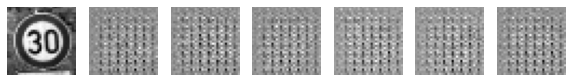

Epoch 10 g_loss= 0.8145407 d_loss= 0.68292415 real_acc= 0.0 fake_acc= 1.0
Epoch 11 g_loss= 0.8316824 d_loss= 0.67637694 real_acc= 0.02 fake_acc= 1.0
Epoch 12 g_loss= 0.8375835 d_loss= 0.67749 real_acc= 0.06 fake_acc= 1.0
Epoch 13 g_loss= 0.8406367 d_loss= 0.680424 real_acc= 0.06 fake_acc= 1.0
Epoch 14 g_loss= 0.8460142 d_loss= 0.6783899 real_acc= 0.02 fake_acc= 1.0
Epoch 15 g_loss= 0.8505456 d_loss= 0.6613496 real_acc= 0.06 fake_acc= 1.0
Epoch 16 g_loss= 0.8630027 d_loss= 0.65900487 real_acc= 0.02 fake_acc= 1.0
Epoch 17 g_loss= 0.8577484 d_loss= 0.6668581 real_acc= 0.08 fake_acc= 1.0
Epoch 18 g_loss= 0.86582595 d_loss= 0.6542081 real_acc= 0.08 fake_acc= 1.0
Epoch 19 g_loss= 0.864529 d_loss= 0.6664237 real_acc= 0.14 fake_acc= 1.0


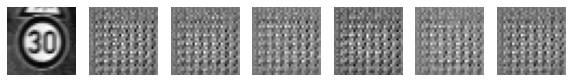

Epoch 20 g_loss= 0.8593493 d_loss= 0.6536579 real_acc= 0.2 fake_acc= 1.0
Epoch 21 g_loss= 0.8575546 d_loss= 0.649584 real_acc= 0.34 fake_acc= 1.0
Epoch 22 g_loss= 0.8438372 d_loss= 0.66997707 real_acc= 0.18 fake_acc= 1.0
Epoch 23 g_loss= 0.83624476 d_loss= 0.65364134 real_acc= 0.26 fake_acc= 1.0
Epoch 24 g_loss= 0.82735807 d_loss= 0.6538545 real_acc= 0.36 fake_acc= 1.0
Epoch 25 g_loss= 0.8183443 d_loss= 0.6539445 real_acc= 0.5 fake_acc= 1.0
Epoch 26 g_loss= 0.79632616 d_loss= 0.6578052 real_acc= 0.48 fake_acc= 1.0
Epoch 27 g_loss= 0.7918919 d_loss= 0.66655195 real_acc= 0.44 fake_acc= 1.0
Epoch 28 g_loss= 0.76834214 d_loss= 0.6566139 real_acc= 0.58 fake_acc= 0.98
Epoch 29 g_loss= 0.7637526 d_loss= 0.6646278 real_acc= 0.52 fake_acc= 1.0


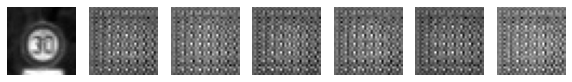

Epoch 30 g_loss= 0.7483002 d_loss= 0.6805037 real_acc= 0.48 fake_acc= 0.98
Epoch 31 g_loss= 0.7483704 d_loss= 0.6654986 real_acc= 0.64 fake_acc= 0.96
Epoch 32 g_loss= 0.7258183 d_loss= 0.66983426 real_acc= 0.64 fake_acc= 0.86
Epoch 33 g_loss= 0.7119017 d_loss= 0.6852659 real_acc= 0.56 fake_acc= 0.8
Epoch 34 g_loss= 0.69864535 d_loss= 0.6915607 real_acc= 0.54 fake_acc= 0.64
Epoch 35 g_loss= 0.69770944 d_loss= 0.6916161 real_acc= 0.64 fake_acc= 0.56
Epoch 36 g_loss= 0.68872833 d_loss= 0.70503134 real_acc= 0.58 fake_acc= 0.4
Epoch 37 g_loss= 0.68062097 d_loss= 0.70418155 real_acc= 0.54 fake_acc= 0.34
Epoch 38 g_loss= 0.687002 d_loss= 0.7105597 real_acc= 0.4 fake_acc= 0.46
Epoch 39 g_loss= 0.68177223 d_loss= 0.72532374 real_acc= 0.3 fake_acc= 0.4


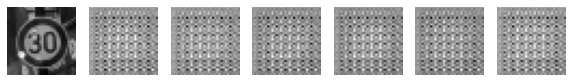

Epoch 40 g_loss= 0.6782523 d_loss= 0.7168083 real_acc= 0.48 fake_acc= 0.36
Epoch 41 g_loss= 0.69713664 d_loss= 0.7086288 real_acc= 0.38 fake_acc= 0.52
Epoch 42 g_loss= 0.70044255 d_loss= 0.7198385 real_acc= 0.34 fake_acc= 0.66
Epoch 43 g_loss= 0.6997626 d_loss= 0.731169 real_acc= 0.32 fake_acc= 0.66
Epoch 44 g_loss= 0.71254003 d_loss= 0.70751315 real_acc= 0.38 fake_acc= 0.72
Epoch 45 g_loss= 0.7081068 d_loss= 0.70391333 real_acc= 0.44 fake_acc= 0.68
Epoch 46 g_loss= 0.7095956 d_loss= 0.71360254 real_acc= 0.34 fake_acc= 0.7
Epoch 47 g_loss= 0.7158528 d_loss= 0.7130599 real_acc= 0.32 fake_acc= 0.74
Epoch 48 g_loss= 0.721298 d_loss= 0.71087384 real_acc= 0.36 fake_acc= 0.78
Epoch 49 g_loss= 0.72314614 d_loss= 0.6914799 real_acc= 0.36 fake_acc= 0.78


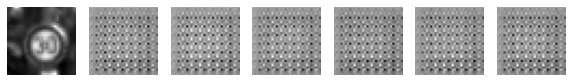

Epoch 50 g_loss= 0.7258247 d_loss= 0.69731 real_acc= 0.38 fake_acc= 0.84
Epoch 51 g_loss= 0.73630464 d_loss= 0.6991478 real_acc= 0.42 fake_acc= 0.88
Epoch 52 g_loss= 0.73376435 d_loss= 0.6979321 real_acc= 0.4 fake_acc= 0.84
Epoch 53 g_loss= 0.74053055 d_loss= 0.69998074 real_acc= 0.28 fake_acc= 0.88
Epoch 54 g_loss= 0.74093 d_loss= 0.6870003 real_acc= 0.4 fake_acc= 0.92
Epoch 55 g_loss= 0.7446655 d_loss= 0.683308 real_acc= 0.5 fake_acc= 0.94
Epoch 56 g_loss= 0.74869585 d_loss= 0.6868975 real_acc= 0.42 fake_acc= 0.92
Epoch 57 g_loss= 0.7446576 d_loss= 0.6825572 real_acc= 0.4 fake_acc= 0.9
Epoch 58 g_loss= 0.7542176 d_loss= 0.6880119 real_acc= 0.36 fake_acc= 0.96
Epoch 59 g_loss= 0.7583275 d_loss= 0.6880721 real_acc= 0.4 fake_acc= 0.98


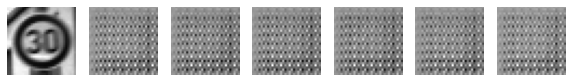

Epoch 60 g_loss= 0.7694324 d_loss= 0.6686587 real_acc= 0.44 fake_acc= 1.0


KeyboardInterrupt: 

In [22]:
epochs = 1000
for e in range(epochs):
    # take some random samples
    new_samples = sample_from_dataset(50,samples)
    # perform one training step (epoch)
    do_step(new_samples)
    epoch += 1
    if epoch % 10 == 0:
        # show one real image and some fake images generated by generator using noise seed
        #display.clear_output(wait=True)
        num_examples_to_generate = 6
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        predictions = generator(seed, training=False)
        fig = plt.figure(figsize=(10,10))
        r = random.randrange(len(samples))
        plt.subplot(1, num_examples_to_generate+1, 1)
        plt.imshow(samples[r, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        for i in range(predictions.shape[0]):
            plt.subplot(1, num_examples_to_generate+1, i+2)
            #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()    
print("Done")

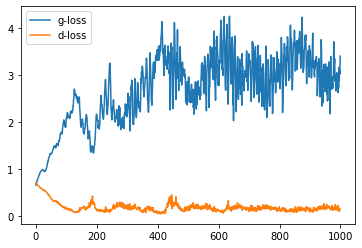

In [14]:
nph = np.array(history)

plt.plot(nph[:,0], label='g-loss')
plt.plot(nph[:,1], label='d-loss')
plt.legend()
plt.show()

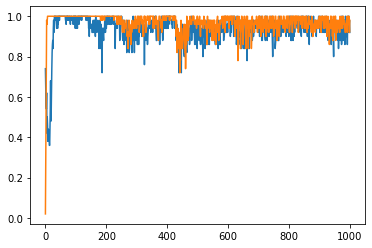

In [15]:
nph = np.array(history)

plt.plot(nph[:,2], label='acc-real')
plt.plot(nph[:,3], label='acc-fake')
plt.show()